In [3]:
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as text
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [4]:
preprocessed_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_URL = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [5]:
preprocessed_bert = hub.KerasLayer(preprocessed_url)
bert_model = hub.KerasLayer(bert_URL)

In [6]:
df = pd.read_csv("spam.csv", encoding="latin1")

In [7]:
df.rename(columns={"v1": "target", "v2": "text"}, inplace=True)
df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"],axis=1,  inplace=True)

In [8]:
spam = df[df["target"]=="spam"]

In [9]:
ham = df[df["target"]=="ham"]

In [10]:
ham = ham.sample(spam.shape[0])

In [11]:
ham.shape

(747, 2)

In [12]:
spam.shape

(747, 2)

In [13]:
dataset = pd.concat([ham, spam])

In [14]:
def converter(text):
    if text ==  "spam":
        return 1
    else:
        return 0

In [15]:
dataset["target"] = dataset["target"].apply(converter)

In [16]:
dataset

,target,text
4117,0,Watch lor. I saw a few swatch one i thk quite ...
3944,0,I will be gentle princess! We will make sweet ...
4016,0,Eek that's a lot of time especially since Amer...
793,0,Omg I want to scream. I weighed myself and I l...
1844,0,Da is good good player.why he is unsold.
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [17]:
X_train, X_test, y_train, y_test = train_test_split(dataset["text"],dataset["target"], test_size=0.2, stratify=dataset["target"] )

In [18]:
y_train.value_counts()

0    598
1    597
Name: target, dtype: int64

In [19]:
input_txt = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
process_txt = preprocessed_bert(input_txt)
output = bert_model(process_txt)

l = tf.keras.layers.Dropout(0.1, name= "dropout")(output["pooled_output"])
l = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(l)

model = tf.keras.Model(inputs=[input_txt], outputs=[l])


In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [21]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [22]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
38/38 [==============================] - 32s 389ms/step - loss: 0.6371 - accuracy: 0.6268 - precision: 0.6355 - recall: 0.5930
Epoch 2/10
38/38 [==============================] - 15s 401ms/step - loss: 0.5046 - accuracy: 0.8126 - precision: 0.7919 - recall: 0.8476
Epoch 3/10
38/38 [==============================] - 15s 404ms/step - loss: 0.4397 - accuracy: 0.8536 - precision: 0.8425 - recall: 0.8693
Epoch 4/10
38/38 [==============================] - 15s 403ms/step - loss: 0.3858 - accuracy: 0.8795 - precision: 0.8624 - recall: 0.9028
Epoch 5/10
38/38 [==============================] - 15s 402ms/step - loss: 0.3588 - accuracy: 0.8795 - precision: 0.8647 - recall: 0.8995
Epoch 6/10
38/38 [==============================] - 15s 406ms/step - loss: 0.3328 - accuracy: 0.8887 - precision: 0.8779 - recall: 0.9028
Epoch 7/10
38/38 [==============================] - 15s 405ms/step - loss: 0.3172 - accuracy: 0.8979 - precision: 0.8776 - recall: 0.9246
Epoch 8/10
38/38 [================

In [23]:
def y_predictor(num):
    if num >0.5:
        return 1
    elif num < 0.5:
        return 0

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(X_test)


10/10 [==============================] - 5s 397ms/step


In [25]:
y_pred = y_pred.flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)


In [26]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[140,   9],
       [ 16, 134]], dtype=int64)

In [27]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       149
           1       0.94      0.89      0.91       150

    accuracy                           0.92       299
   macro avg       0.92      0.92      0.92       299
weighted avg       0.92      0.92      0.92       299



Text(50.722222222222214, 0.5, 'Truth')

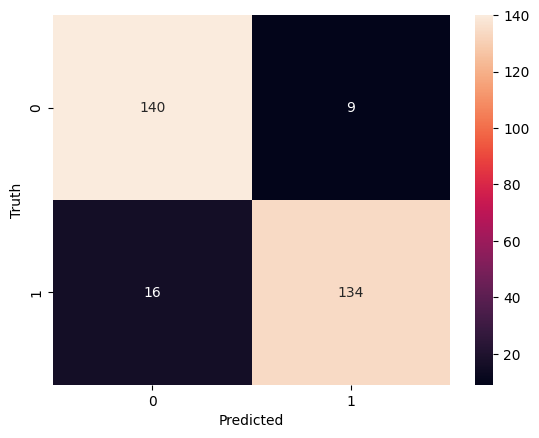

In [28]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [29]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 1s 1s/step


array([[0.7362407 ],
       [0.82490975],
       [0.76212376],
       [0.17226143],
       [0.07379062]], dtype=float32)